# Initialization

In [1]:
%%python


# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
%%python

# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

In [3]:
%%python

import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"Jupyter Kernel via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Jupyter Kernel via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.3`

In [4]:
gSystem->Load("libg4dst")

(int) 0


# Inputs

In [5]:


// TFile * fpythia8_ref = TFile::Open("test_crossDivNrg_25mRad_18x275_v1.hist.root");
TFile * fpythia8_ref = TFile::Open("headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root");
 
TFile * fdst_reader = TFile::Open("headonTestJin/G4EICDetector_DSTReader_-25mrad_1M_9a8e3b0b4.root");

TString description ("e+p, 18x275 GeV, 25mRad x-ing");
cout << description <<endl;

e+p, 18x275 GeV, 25mRad x-ing


In [6]:
%%cpp -d

// $Id: $

/*!
 * \file makeRAA_BUP2020.C
 * \brief 
 * \author Jin Huang <jhuang@bnl.gov>
 * \version $Revision:   $
 * \date $Date: $
 */

#include "sPhenixStyle.C"

#include <TChain.h>
#include <TCut.h>
#include <TEfficiency.h>
#include <TF1.h>
#include <TGraphAsymmErrors.h>
#include <TGraphErrors.h>
#include <TH2.h>
#include <TH3.h>
#include <TPolyLine.h>

#include <TFile.h>

#include <TColor.h>
#include <TLatex.h>
#include <TLegend.h>
#include <TLine.h>
#include <TStyle.h>

#include <TMath.h>
#include <TPad.h>
#include <TString.h>
#include <TTree.h>
#include <TVectorD.h>
#include <TVirtualFitter.h>

#include <cmath>
#include <iostream>

using namespace std;
// ROOT6 disabled assert. Well....
#ifdef assert
#undef assert
#endif
#define assert(exp)                                                                             \
  {                                                                                             \
    if (!(exp))                                                                                 \
    {                                                                                           \
      cout << "Assert (" << #exp << ") failed at " << __FILE__ << " line " << __LINE__ << endl; \
    }                                                                                           \
  }

In [7]:
SetsPhenixStyle();
gStyle->SetOptStat(0);
gStyle->SetOptFit(1111);
TVirtualFitter::SetDefaultFitter("Minuit2");

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


In [8]:
%%cpp -d



//! Service function to SaveCanvas()
void
SavePad(TPad * p)
{
  if (!p)
    return;

  TList * l = p->GetListOfPrimitives();
//  l->Print();

  TIter next(l);
  TObject *obj = NULL;
  while ((obj = next()))
    {

      if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TPad")) >= 0)
        {
          if ((TPad *) obj != p)
            SavePad((TPad *) obj);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TH1")) >= 0)
        {
          cout << "Save TH1 " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TF1")) >= 0)
        {
          cout << "Save TF1 " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TGraph")) >= 0)
        {
          cout << "Save TGraph " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
      else if (obj->IsA()->GetBaseClassOffset(TClass::GetClass("TEfficiency")) >= 0)
        {
          cout << "Save TEfficiency " << obj->GetName() << endl;
          obj->Clone()->Write(obj->GetName(), TObject::kOverwrite);
        }
    }
}



//! Save canvas to multiple formats
/*!
 *  @param[in] c    pointer to the canvas
 *  @param[in] name Base of the file name. The default is the name of the cavas
 *  @param[in] bEPS true = save .eps and .pdf format too.
 */
void
SaveCanvas(TCanvas * c, TString name = "", Bool_t bEPS = kTRUE)
{
  if (name.Length() == 0)
    name = c->GetName();

  c->Print(name + ".png");

  TDirectory * oldd = gDirectory;

  TString rootfilename;

  c->Print(rootfilename = name + ".root");

  TFile f(rootfilename, "update");

  SavePad(c);

  f.Close();

  oldd->cd();

  if (bEPS)
    {
//      c->Print(name + ".pdf");

      float x = 20;
      float y = 20;
      gStyle->GetPaperSize(x, y);

      gStyle->SetPaperSize(c->GetWindowWidth() / 72 * 2.54,
          c->GetWindowHeight() / 72 * 2.54);
      c->Print(name + ".eps");
      c->Print(name + ".svg");
      gSystem->Exec("rsvg-convert -f pdf -o "+name + ".pdf " + name + ".svg");
      gSystem->Exec("rm -fv " +  name + ".svg");

      gStyle->SetPaperSize(x, y);
    }
    c->Print(name+".C");
}

In [9]:
//! Draw 1D histogram along with its reference as shade
//! @param[in] draw_href_error whether to draw error band for reference plot. Otherwise, it is a filled histogram (default)
double DrawReference(TH1 *hnew, TH1 *href, bool draw_href_error = false, bool do_kstest = false)
{
  hnew = (TH1 *)hnew->Clone();
  hnew->SetTitle(TString(hnew->GetTitle()) + ", " + description);
    
    
  hnew->SetLineColor(kBlue + 3);
  hnew->SetMarkerColor(kBlue + 3);
  //  hnew->SetLineWidth(2);
  hnew->SetMarkerStyle(kFullCircle);
  //  hnew->SetMarkerSize(1);

  if (href)
  {
    if (draw_href_error)
    {
      href->SetLineColor(kGreen + 1);
      href->SetFillColor(kGreen + 1);
      href->SetLineStyle(kSolid);
      href->SetMarkerColor(kGreen + 1);
      //      href->SetLineWidth(2);
      href->SetMarkerStyle(kDot);
      href->SetMarkerSize(0);
    }
    else
    {
      href->SetLineColor(kGreen + 1);
      href->SetFillColor(kGreen + 1);
      href->SetLineStyle(0);
      href->SetMarkerColor(kGreen + 1);
      href->SetLineWidth(0);
      href->SetMarkerStyle(kDot);
      href->SetMarkerSize(0);
    }
  }    

  TH1* hc = (TH1*)hnew->DrawClone();  // set scale

  double ks_test = numeric_limits<double>::signaling_NaN();

  if (href)
  {
    if (draw_href_error)
    {
      href->DrawClone("E2 same");
      href->SetFillStyle(0);
      href->SetLineWidth(8);
      href->DrawClone("HIST same ][");
    }
    else
      href->DrawClone("HIST same");
    TH1* hc = (TH1*)hnew->DrawClone("same");  // over lay data points
      hc->SetTitle(TString(hnew->GetTitle()) + ", " + description);

    if (do_kstest)
      ks_test = hnew->KolmogorovTest(href, "");
  }

  // ---------------------------------
  // now, make summary header
  // ---------------------------------
  if (href)
  {
    gPad->SetTopMargin(.14);
    TLegend *legend = new TLegend(0, .93, 0, 1, hnew->GetTitle(), "NB NDC");
    legend->Draw();
    legend = new TLegend(0, .86, .4, .93, NULL, "NB NDC");
    legend->AddEntry(href, Form("Pyt8 BeamShape"), "f");
    legend->Draw();
    legend = new TLegend(0.4, .86, 1, .93, NULL, "NB NDC");

    if (do_kstest)
    {
      TLegendEntry *le = legend->AddEntry(hnew, Form("New: KS-Test P=%.3f", ks_test), "lpe");
      if (ks_test >= 1)
        le->SetTextColor(kBlue + 1);
      else if (ks_test >= .2)
        le->SetTextColor(kGreen + 2);
      else if (ks_test >= .05)
        le->SetTextColor(kYellow + 1);
      else
        le->SetTextColor(kRed + 1);
      legend->Draw();
    }
    else
    {
      TLegendEntry *le = legend->AddEntry(hnew, Form("Fun4All X-ing AfterBurner"), "lpe");
      legend->Draw();
    }
  }
  else
  {
    gPad->SetTopMargin(.07);
    TLegend *legend = new TLegend(0, .93, 0, 1, hnew->GetTitle(), "NB NDC");
    legend->Draw();
  }


  return ks_test;
}

In [10]:

//! Draw 1D histogram along with its reference as shade
//! @param[in] draw_href_error whether to draw error band for reference plot. Otherwise, it is a filled histogram (default)
void DrawRatio(TH1 *hnew, TH1 *href, const int rebin = 1)
{
  hnew->SetLineColor(kBlue + 3);
  hnew->SetMarkerColor(kBlue + 3);
  //  hnew->SetLineWidth(2);
  hnew->SetMarkerStyle(kFullCircle);
  //  hnew->SetMarkerSize(1);

  if (not href)
  {
      cout <<"Error no reference!" << endl;
      return;
  }
  
  href = (TH1 *)( href->Clone(TString(href->GetName()) + "_clone") ); 
  href->SetDirectory(nullptr);
  href -> Rebin(rebin);
    
  TH1 * hnew_ratio = (TH1 *)( hnew->Clone(TString(hnew->GetName()) + "_ratio") ); 
  hnew_ratio->SetTitle(TString(hnew->GetTitle()) + " Ratio, " + description);
  hnew_ratio -> Rebin(rebin);
  hnew_ratio->SetDirectory(nullptr);
  hnew_ratio->Divide(href);
  hnew_ratio->SetMaximum(1+ 0.02);
  hnew_ratio->SetMinimum(1- 0.02);
  hnew_ratio->GetYaxis()->SetTitle("Ratio");
  hnew_ratio->Draw();

  // ---------------------------------
  // now, make summary header
  // ---------------------------------
  if (href)
  {
      
    gPad->SetTopMargin(.14);
    TLegend *legend = new TLegend(0, .93, 0, 1, hnew->GetTitle(), "NB NDC");
    legend->Draw();
    legend->Draw();
    legend = new TLegend(0., .86, 1, .93, NULL, "NB NDC");

    TLegendEntry *le = legend->AddEntry(hnew, Form("Fun4All X-ing AfterBurner/Pythia8 BeamShape"), "lpe");
    legend->Draw();
    
  }


  return ;
}

## Input file check

In [11]:
assert(fdst_reader->IsOpen());
fdst_reader->ls();

TFile**		headonTestJin/G4EICDetector_DSTReader_-25mrad_1M_9a8e3b0b4.root	
 TFile*		headonTestJin/G4EICDetector_DSTReader_-25mrad_1M_9a8e3b0b4.root	
  KEY: TTree	T;63	PHG4DSTReader
  KEY: TTree	T;62	PHG4DSTReader


In [12]:
TTree * T = (TTree *)( fdst_reader->Get("T"));
assert(T);
T->Show(0);

======> EVENT:0
 n_G4HIT_BH_1    = 0
 n_G4HIT_BH_FORWARD_PLUS = 0
 n_G4HIT_BH_FORWARD_NEG = 0
 n_PHG4Particle  = 2
 PHG4Particle    = 2
 PHG4Particle.fUniqueID = 0, 0
 PHG4Particle.fBits = 50331648, 50331648
 PHG4Particle.fname = proton, e-
 PHG4Particle.fpid = 2212, 11
 PHG4Particle.fpx = -6.85194, 0.00518088
 PHG4Particle.fpy = -0.0322916, 0.00455106
 PHG4Particle.fpz = 274.936, -20.0015
 PHG4Particle.barcode = -1, -1
 PHG4Particle.trkid = 1, 2
 PHG4Particle.vtxid = 1, 1
 PHG4Particle.parentid = 0, 0
 PHG4Particle.primaryid = 1, 2
 PHG4Particle.fe = 275.023, 20.0015
 n_PHG4VtxPoint  = 1
 PHG4VtxPoint    = 1
 PHG4VtxPoint.fUniqueID = 0
 PHG4VtxPoint.fBits = 50331648
 PHG4VtxPoint.vx = -0.00258765
 PHG4VtxPoint.vy = 0.00033557
 PHG4VtxPoint.vz = 2.8655
 PHG4VtxPoint.t0 = -0.109908
 PHG4VtxPoint.id = 1


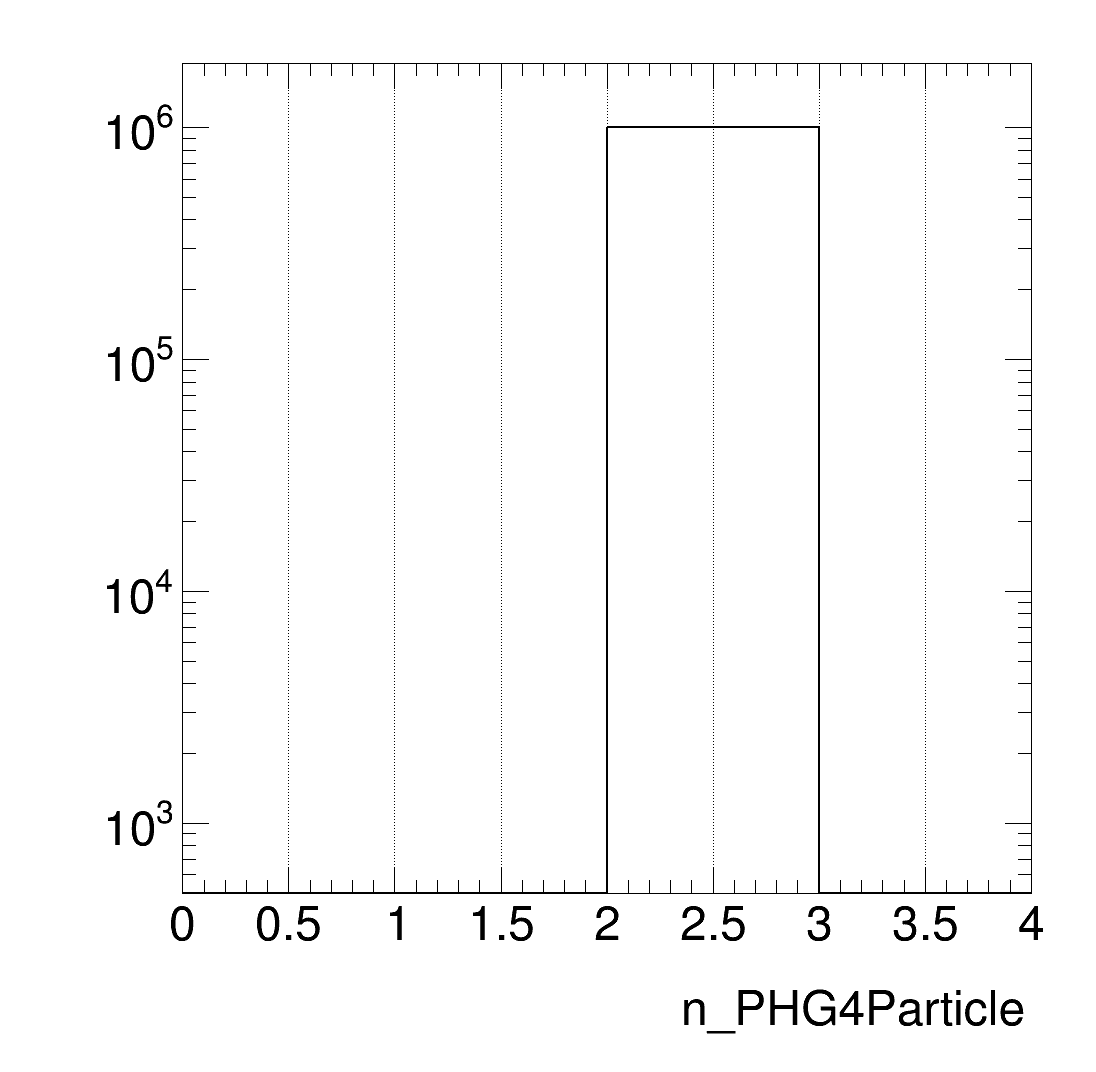

In [13]:
{
    
    TCanvas *c1 = new TCanvas("partPhi" ,
                  "partPhi" , 1100, 1100);
    
     c1->Divide(1,1);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogy();

        T->Draw("n_PHG4Particle");
          
      }
    
    c1->Draw();
//     SaveCanvas(c1, TString(fpythia8_ref->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}

In [14]:
// tracks->SetAlias("gpt","1*sqrt(gpx**2+gpy**2)");
// tracks->SetAlias("gp","1*sqrt(gpx**2+gpy**2+gpz**2)");
// tracks->SetAlias("gpphi","1*atan2(gpy,gpx)");
// tracks->SetAlias("gpeta","0.5*log((gp + gpz)/(gp - gpz))");

## Ref file dump

In [15]:
fpythia8_ref->ls()

TFile**		headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root	
 TFile*		headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root	
  KEY: TH1D	q2Hist;1	Log Q2
  KEY: TH1D	yHist;1	Inelasticity
  KEY: TH2D	phaseSpaceHist;1	Log Q2 Vs Log x
  KEY: TH1D	eCM;1	Modified - Nominal CM Energy
  KEY: TH2D	pXY1;1	Hadron Beam Py Vs Px
  KEY: TH2D	pXZProd1;1	Hadron Beam Px Vs Vertex z
  KEY: TH2D	pYZProd1;1	Hadron Beam Py Vs Vertex z
  KEY: TH2D	pXY2;1	Lepton Beam Py Vs Px
  KEY: TH2D	pXZProd2;1	Lepton Beam Px Vs Vertex z
  KEY: TH2D	pYZProd2;1	Lepton Beam Py Vs Vertex z
  KEY: TH1D	pZ1;1	Hadron Beam Pz
  KEY: TH1D	pZ2;1	Lepton Beam Pz
  KEY: TH1D	atan2PxPz1;1	
  KEY: TH1D	atan2PyPz1;1	
  KEY: TH1D	atan2PyPtot1;1	
  KEY: TH1D	vtxX;1	Vertex x
  KEY: TH1D	vtxY;1	Vertex y
  KEY: TH1D	vtxZ;1	Vertex z
  KEY: TH1D	vtxT;1	Time
  KEY: TH2D	vtxYvsX;1	Vertex Y vs X
  KEY: TH2D	vtxXvsT;1	Vertex X vs T
  KEY: TH2D	vtxXvsZ;1	Vertex X vs Z
  KEY: TH2D	vtxYvsZ;1	Vertex Y vs Z
  KEY: TH2D	vtxTvsZ;1	I

# Vertex check

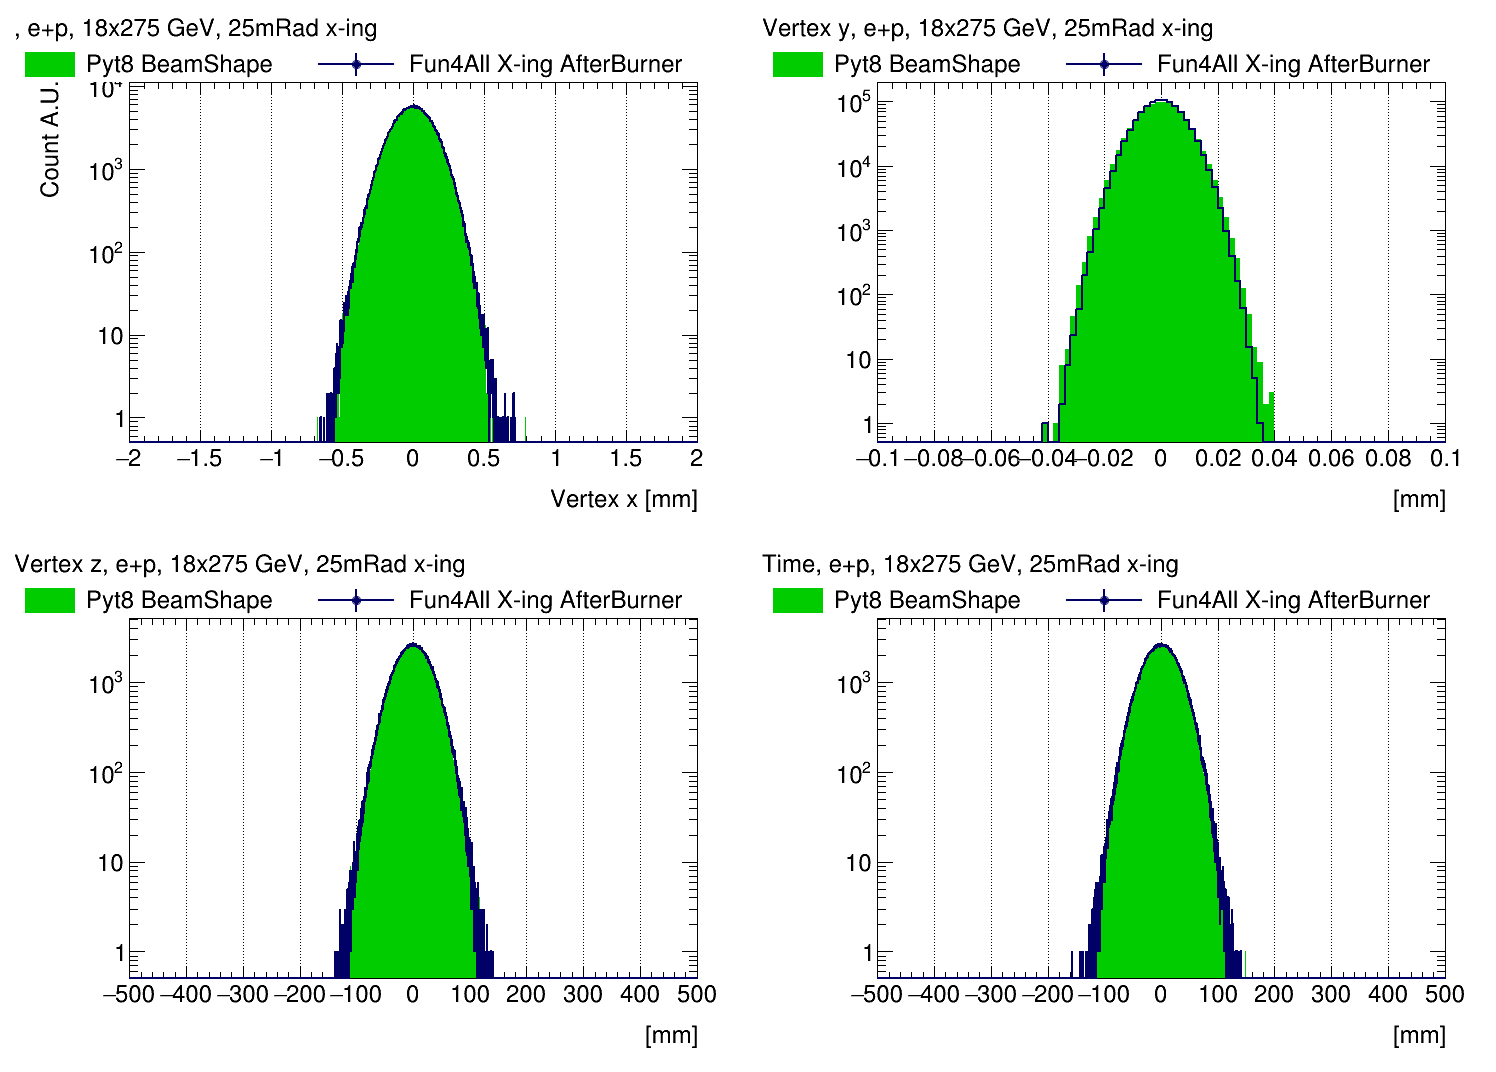

vtxX->GetRMS() = 0.140526, hvtxX->GetRMS() = 0.140797
hvtxY->GetSumOfWeights() = 999993
hvtxY->GetSumOfWeights() = 0, hvtxY->GetName() = hvtxY
hvtxY->GetSumOfWeights() = 1e+06
vtxY->GetRMS() = 0.0079983, hvtxY->GetRMS() = 0.00753739
vtxZ->GetRMS() = 30.3164, hvtxZ->GetRMS() = 30.3496
vtxT->GetRMS() = 30.3272, hvtxT->GetRMS() = 30.349
Save TH1 hvtxX
Save TH1 vtxX
Save TH1 hvtxX
Save TH1 hvtxY
Save TH1 vtxY
Save TH1 hvtxY
Save TH1 hvtxZ
Save TH1 vtxZ
Save TH1 hvtxZ
Save TH1 hvtxT
Save TH1 vtxT
Save TH1 hvtxT
removed ‘headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCheck.svg’


Info in <TCanvas::Print>: png file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCheck.png has been created
Info in <TCanvas::SaveAs>: ROOT file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCheck.root has been created
Info in <TCanvas::Print>: eps file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCheck.eps has been created
Info in <TCanvas::Print>: SVG file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCheck.svg has been created
Info in <TCanvas::SaveSource>: C++ Macro file: headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCheck.C has been generated


In [16]:
{
    
    
    TCanvas *c1 = new TCanvas("VertexCheck" ,
                  "VertexCheck" , 1500, 1100);
    
     c1->Divide(2, 2);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogy();

        TH1 * vtxX= (TH1 *)fpythia8_ref->Get("vtxX");
        //vtxX->Draw();
          
        TH1 * hvtxX = (TH1 *) vtxX->Clone("hvtxX");
        hvtxX->Reset();
        T->Draw("-PHG4VtxPoint.vx * 10>>hvtxX","","goff");
          
        vtxX -> Scale(hvtxX->GetSumOfWeights() *1. / vtxX->GetSumOfWeights());
          
        hvtxX->GetXaxis()->SetRangeUser(-2,2);
        cout << "vtxX->GetRMS() = " << vtxX->GetRMS()<<", hvtxX->GetRMS() = "<<hvtxX->GetRMS()<<endl;
          hvtxX->SetTitle(";Vertex x [mm];Count A.U.");
        DrawReference(hvtxX, vtxX, false);
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogy();

        TH1 * vtxY= (TH1 *)fpythia8_ref->Get("vtxY");
//         vtxY->Draw();
          
          
          
        TH1 * hvtxY = (TH1 *) vtxY->Clone("hvtxY");
        cout << "hvtxY->GetSumOfWeights() = " << hvtxY->GetSumOfWeights()<<endl;
        hvtxY->Reset();
        cout << "hvtxY->GetSumOfWeights() = " << hvtxY->GetSumOfWeights()<<", hvtxY->GetName() = "<<hvtxY->GetName()<<endl;
        T->Draw("PHG4VtxPoint.vy  * 10 >>hvtxY","","goff");
        cout << "hvtxY->GetSumOfWeights() = " << hvtxY->GetSumOfWeights()<<endl;
        cout << "vtxY->GetRMS() = " << vtxY->GetRMS()<<", hvtxY->GetRMS() = "<<hvtxY->GetRMS()<<endl;
          
        vtxY -> Scale(hvtxY->GetSumOfWeights() *1. / vtxY->GetSumOfWeights());
        hvtxY->GetXaxis()->SetRangeUser(-.1,.1);
          hvtxX->SetTitle(";Vertex y [mm];Count A.U.");
        DrawReference(hvtxY, vtxY, false);
          
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogy();

        TH1 * vtxZ= (TH1 *)fpythia8_ref->Get("vtxZ");
//         vtxZ->Draw();
          
          
        TH1 * hvtxZ = (TH1 *) vtxZ->Clone("hvtxZ");
        hvtxZ->Reset();
        T->Draw("PHG4VtxPoint.vz * 10>>hvtxZ","","goff");
          
        vtxZ -> Scale(hvtxZ->GetSumOfWeights() *1. / hvtxZ->GetSumOfWeights());
          
//         hvtxZ->GetXaxis()->SetRangeUser(-1,1);
          hvtxX->SetTitle(";Vertex z [mm];Count A.U.");
        DrawReference(hvtxZ, vtxZ, false);
          
        cout << "vtxZ->GetRMS() = " << vtxZ->GetRMS()<<", hvtxZ->GetRMS() = "<<hvtxZ->GetRMS()<<endl;
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetLogy();

        TH1 * vtxT= (TH1 *)fpythia8_ref->Get("vtxT");
        vtxT->Draw();
          
        TH1 * hvtxT = (TH1 *) vtxT->Clone("hvtxT");
        hvtxT->Reset();
        T->Draw("PHG4VtxPoint.t0 * 299.8>>hvtxT","","goff");
          
        vtxT -> Scale(hvtxT->GetSumOfWeights() *1. / vtxT->GetSumOfWeights());
          
//         hvtxZ->GetXaxis()->SetRangeUser(-1,1);
        DrawReference(hvtxT, vtxT, false);
          hvtxT->SetTitle(";Vertex c*t [mm];Count A.U.");
        cout << "vtxT->GetRMS() = " << vtxT->GetRMS()<<", hvtxT->GetRMS() = "<<hvtxT->GetRMS()<<endl;
      }


    c1->Draw();
    SaveCanvas(c1, TString(fpythia8_ref->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}

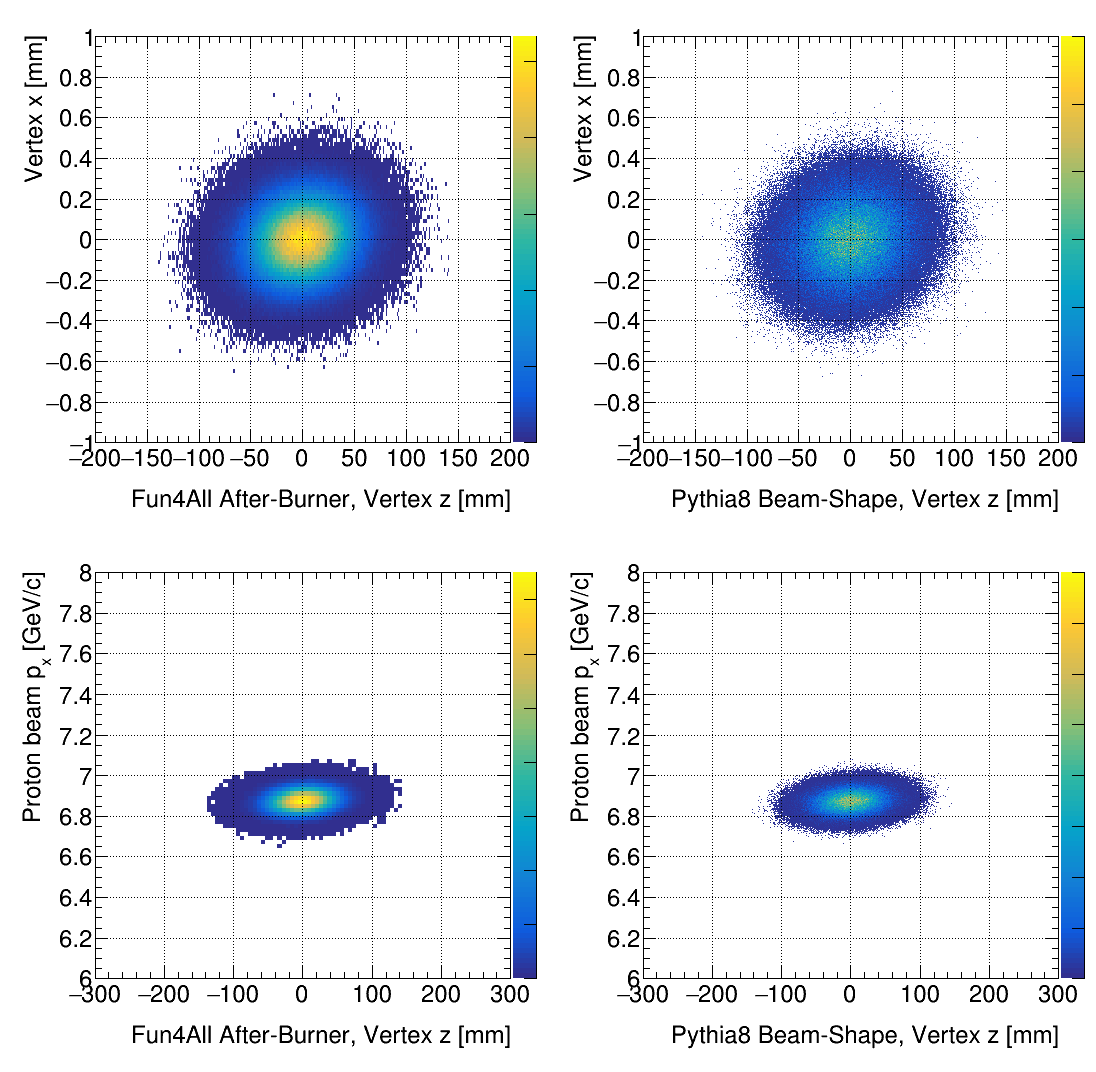

Save TH1 hvtxXvsZ
Save TH1 vtxXvsZ
Save TH1 hpXZProd1
Save TH1 pXZProd1
removed ‘headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.svg’


Info in <TCanvas::Print>: png file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.png has been created
Info in <TCanvas::SaveAs>: ROOT file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.root has been created
Info in <TCanvas::Print>: eps file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.eps has been created
Info in <TCanvas::Print>: SVG file headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.svg has been created
Error reading SVG:Error domain 1 code 1 on line 316738 column 1 of file:///gpfs/mnt/gpfs02/sphenix/sim/sim01/phnxreco/users/jinhuang/simulation/analysis-ecce/BeamXingCheck/headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.svg: internal error: Huge input lookup


Info in <TCanvas::SaveSource>: C++ Macro file: headonTestJin/test_crossDivNrgCrab_25mRad_18x275_v1a.hist.root_VertexCorrelation.C has been generated


In [17]:
{
    
    TCanvas *c1 = new TCanvas("VertexCorrelation" ,
                  "VertexCorrelation" , 1100, 1100);
    
     c1->Divide(2,2);
      int idx = 1;
      TPad *p;

      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetGridy();

        T->Draw("-PHG4VtxPoint.vx * 10: PHG4VtxPoint.vz * 10 >>hvtxXvsZ(300,-200,200,100,-1,1)","","colz");
        TH1 * hvtxXvsZ = (TH1 *) gDirectory->Get("hvtxXvsZ");
          
          hvtxXvsZ->SetTitle(";Fun4All After-Burner, Vertex z [mm];Vertex x [mm]");
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetGridy();

        TH1 * vtxXvsZ= (TH1 *)fpythia8_ref->Get("vtxXvsZ");
          
        vtxXvsZ->GetXaxis()->SetRangeUser(-200,200);
        vtxXvsZ->GetYaxis()->SetRangeUser(-1,1);
          
        vtxXvsZ->Draw("colz");
          
          vtxXvsZ->SetTitle(";Pythia8 Beam-Shape, Vertex z [mm];Vertex x [mm]");
      }
    
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetGridy();

        T->Draw("-PHG4Particle[0].fpx : PHG4VtxPoint.vz * 10 >>hpXZProd1(100,-300,300,100,6,8)","","colz");
          
        TH1 * hpXZProd1 = (TH1 *) gDirectory->Get("hpXZProd1");
          
          hpXZProd1->SetTitle(";Fun4All After-Burner, Vertex z [mm];Proton beam p_{x} [GeV/c]");
      }
      { 
          

        p = (TPad *)c1->cd(idx++);
        c1->Update();
        p->SetGridx();
        p->SetGridy();

        TH1 * pXZProd1= (TH1 *)fpythia8_ref->Get("pXZProd1");
          
        pXZProd1->GetXaxis()->SetRangeUser(-300,300);
        pXZProd1->GetYaxis()->SetRangeUser(6,8);
          
        pXZProd1->Draw("colz");
          
          pXZProd1->SetTitle(";Pythia8 Beam-Shape, Vertex z [mm];Proton beam p_{x} [GeV/c]");
      }
    c1->Draw();
    SaveCanvas(c1, TString(fpythia8_ref->GetName() )+"_"+ TString(c1->GetName()), kTRUE);
}